In [2]:
# import the packages used for analysis
import nltk
import pandas as pd
import numpy as np
import string
import regex as re

import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import feature_extraction, model_selection, metrics, svm

In [43]:
import datetime
import spacy
import math
from matplotlib.pyplot import figure
figure(figsize=(8, 6), dpi=80)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [4]:
data = pd.read_csv('whole.csv')      # reading data

In [5]:
data.head(5)

,Unnamed: 0,Time,Title,SubTitle,Declined Offer,Neutral Experience,Average Interview,Application,Interview,InterviewQuestions,date
0,1,"Apr 22, 2022",Legal Counsel Interview,Anonymous Interview Candidate,bad,neutral,neutral,I interviewed at Comcast,Multi-step interview process with long lulls b...,Behavioral questions and questions regarding m...,2022-04-22 00:00:00
1,2,"Apr 21, 2022",Software Engineer Interview,Anonymous Interview Candidate,bad,bad,neutral,I interviewed at Comcast,The interview was conducted online. 2 rounds w...,Describe many to many relationship in a database.,2022-04-21 00:00:00
2,3,"Apr 21, 2022",Customer Account Manager Interview,"Anonymous Employee in Abington, PA",good,bad,good,I applied through a recruiter. The process too...,"Initial online screening, phone screen with re...",Provide an example you overcame adversity,2022-04-21 00:00:00
3,4,"Apr 18, 2022",Digital Marketer Interview,Anonymous Interview Candidate,neutral,neutral,neutral,I interviewed at Comcast,The interview process was pretty standard real...,What have you done before that is similar to w...,2022-04-18 00:00:00
4,5,"Apr 14, 2022",Customer Onboarding Specialist Interview,"Anonymous Interview Candidate in Houston, TX",bad,bad,neutral,I applied online. The process took 4 weeks. I ...,"Applied online received assessment, received c...",What’s a time you had a customer upset and you...,2022-04-14 00:00:00


In [6]:
data['combined'] = data['Interview'] + ' ' +  data['InterviewQuestions']
data.iloc[0].combined

'Multi-step interview process with long lulls between the interviews. The interviews were more substantive as I progressing in the process. The initial interview was simply a screener with human resources. Behavioral questions and questions regarding my experience.'

In [7]:
data.loc[data.date <= '2019-12-31', 'period'] = 1
data.loc[(data.date > '2019-12-31') & (data.date <= '2020-06-30'), 'period'] = 2
data.loc[data.date > '2020-06-30', 'period'] = 3
data['period_count'] = data.groupby('period')['date'].transform(lambda a: len(set(a)))

#### Initialize data

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159667 entries, 0 to 159666
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Unnamed: 0          159667 non-null  int64  
 1   Time                159667 non-null  object 
 2   Title               159667 non-null  object 
 3   SubTitle            159667 non-null  object 
 4   Declined Offer      159667 non-null  object 
 5   Neutral Experience  159667 non-null  object 
 6   Average Interview   159667 non-null  object 
 7   Application         159667 non-null  object 
 8   Interview           159667 non-null  object 
 9   InterviewQuestions  159598 non-null  object 
 10  date                159667 non-null  object 
 11  combined            159598 non-null  object 
 12  period              159667 non-null  float64
 13  period_count        159667 non-null  int64  
dtypes: float64(1), int64(2), object(11)
memory usage: 17.1+ MB


array([[<AxesSubplot:title={'center':'bad'}>,
        <AxesSubplot:title={'center':'good'}>],
       [<AxesSubplot:title={'center':'neutral'}>, <AxesSubplot:>]],
      dtype=object)

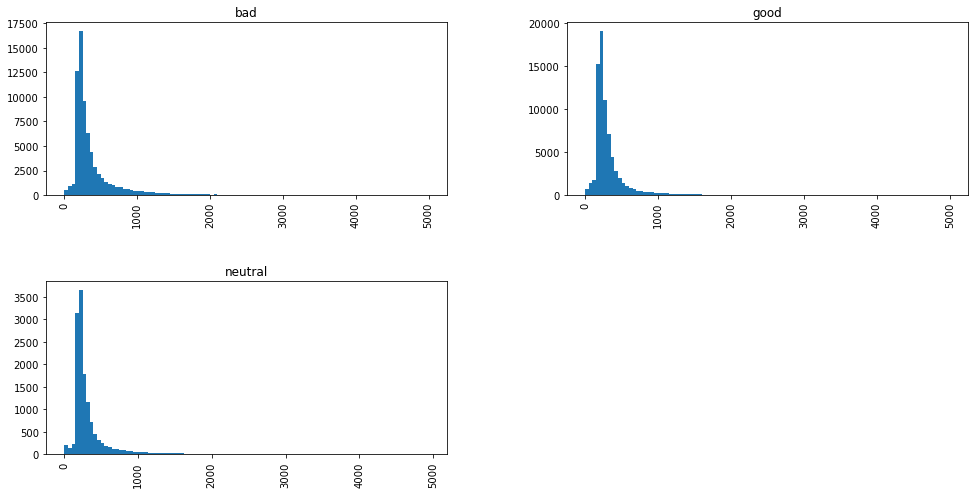

In [9]:
data['length'] = data['Interview'].apply(len)
data.hist(column='length',by='Declined Offer',bins=100, figsize=(16,8))

In [10]:
# Checking null/missing values
data.isnull().sum()

Unnamed: 0             0
Time                   0
Title                  0
SubTitle               0
Declined Offer         0
Neutral Experience     0
Average Interview      0
Application            0
Interview              0
InterviewQuestions    69
date                   0
combined              69
period                 0
period_count           0
length                 0
dtype: int64

In [11]:
data.InterviewQuestions

0         Behavioral questions and questions regarding m...
1         Describe many to many relationship in a database.
2                 Provide an example you overcame adversity
3         What have you done before that is similar to w...
4         What’s a time you had a customer upset and you...
                                ...                        
159662    What is the largest sale you have been involve...
159663    Case Study: Analyze the current state of the h...
159664    Do you think cloud computing will live up to t...
159665        Describe a time when you failed at something.
159666              Why did you choose your degree subject?
Name: InterviewQuestions, Length: 159667, dtype: object

In [12]:
data = data.fillna("")
data

,Unnamed: 0,Time,Title,SubTitle,Declined Offer,Neutral Experience,Average Interview,Application,Interview,InterviewQuestions,date,combined,period,period_count,length
0,1,"Apr 22, 2022",Legal Counsel Interview,Anonymous Interview Candidate,bad,neutral,neutral,I interviewed at Comcast,Multi-step interview process with long lulls b...,Behavioral questions and questions regarding m...,2022-04-22 00:00:00,Multi-step interview process with long lulls b...,3.0,666,204
1,2,"Apr 21, 2022",Software Engineer Interview,Anonymous Interview Candidate,bad,bad,neutral,I interviewed at Comcast,The interview was conducted online. 2 rounds w...,Describe many to many relationship in a database.,2022-04-21 00:00:00,The interview was conducted online. 2 rounds w...,3.0,666,196
2,3,"Apr 21, 2022",Customer Account Manager Interview,"Anonymous Employee in Abington, PA",good,bad,good,I applied through a recruiter. The process too...,"Initial online screening, phone screen with re...",Provide an example you overcame adversity,2022-04-21 00:00:00,"Initial online screening, phone screen with re...",3.0,666,435
3,4,"Apr 18, 2022",Digital Marketer Interview,Anonymous Interview Candidate,neutral,neutral,neutral,I interviewed at Comcast,The interview process was pretty standard real...,What have you done before that is similar to w...,2022-04-18 00:00:00,The interview process was pretty standard real...,3.0,666,225
4,5,"Apr 14, 2022",Customer Onboarding Specialist Interview,"Anonymous Interview Candidate in Houston, TX",bad,bad,neutral,I applied online. The process took 4 weeks. I ...,"Applied online received assessment, received c...",What’s a time you had a customer upset and you...,2022-04-14 00:00:00,"Applied online received assessment, received c...",3.0,666,396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159662,21354,"Feb 23, 2011",Sales Coordinator Interview,Anonymous Interview Candidate in MISSING VALUE,bad,neutral,neutral,I applied online. The process took 4 weeks. I ...,Contacted for initial phone interview. Took th...,What is the largest sale you have been involve...,2011-02-23 00:00:00,Contacted for initial phone interview. Took th...,1.0,3890,501
159663,21355,"Feb 21, 2011",Management Consulting Analyst Interview,"Anonymous Interview Candidate in New York, NY",neutral,bad,good,I applied through an employee referral The pro...,"Overall, the process was well run, however I w...",Case Study: Analyze the current state of the h...,2011-02-21 00:00:00,"Overall, the process was well run, however I w...",1.0,3890,87
159664,21356,"Feb 18, 2011",Manager Interview,"Anonymous Employee in Los Angeles, CA",good,neutral,good,I applied through an employee referral The pro...,This was much more informal than you'd expect....,Do you think cloud computing will live up to t...,2011-02-18 00:00:00,This was much more informal than you'd expect....,1.0,3890,318
159665,21357,"Feb 17, 2011",Financial Analyst Interview,"Anonymous Interview Candidate in Reston, VA",bad,neutral,neutral,I applied online. The process took 3 weeks. I ...,I first had a phone screening with a recruiter...,Describe a time when you failed at something.,2011-02-17 00:00:00,I first had a phone screening with a recruiter...,1.0,3890,344


In fact, the two texts in this experiment were not exactly equal; their ratio was 2:1. But this is the case where I've combined two data sources, and I think that's enough.

#### Preprocess data

In [13]:
# Removing Punctutaion
def clean1(text):
    words = []
    for word in text:
        if word not in string.punctuation:
            words.append(word)
    output= "".join(words)
    return output

In [14]:
# Tokenizing
def clean3(text):
    split=re.split("\W+",text) 
    return split

In [15]:
# Removing Stopwords
stopword = set(stopwords.words('english'))
stopword.add('interview')
stopword.add('question')
stopword.add('the')
stopword.add('i')
stopword.add('recruiter')
def clean2(text):
    return " ".join([word for word in str(text).split() if word not in stopword])

In [16]:
# Tokenizing
def clean3(text):
    split=re.split("\W+",text) 
    return split

In [17]:
# Lemmatizing
'''In order to avoid that the different parts of speech of the 
same word will disturb our analysis, we need to restore their form.'''
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text])

In [18]:
data["combined"][0]

'Multi-step interview process with long lulls between the interviews. The interviews were more substantive as I progressing in the process. The initial interview was simply a screener with human resources. Behavioral questions and questions regarding my experience.'

In [19]:
combined1 = data[data["period"] == 1]["combined"]
combined2 = data[data["period"] == 2]["combined"]
combined3 = data[data["period"] == 3]["combined"]

In [20]:
data[data["period"] == 1]["period_count"]

485       3890
486       3890
487       3890
488       3890
489       3890
          ... 
159662    3890
159663    3890
159664    3890
159665    3890
159666    3890
Name: period_count, Length: 105307, dtype: int64

In [21]:
data[data["period"] == 2]["period_count"]

430       182
431       182
432       182
433       182
434       182
         ... 
146779    182
146780    182
146781    182
146782    182
146783    182
Name: period_count, Length: 5161, dtype: int64

In [22]:
data[data["period"] == 3]["period_count"]

0         666
1         666
2         666
3         666
4         666
         ... 
146124    666
146125    666
146126    666
146127    666
146128    666
Name: period_count, Length: 49199, dtype: int64

In [23]:
period1count=3890
period2count=182
period3count=666

In [24]:
def dataprocessing(target):
    target = target.apply(lambda x: clean1(x))
    target = target.apply(lambda x: clean3(x))
    target = target.apply(lambda x: clean2(x))
    target = target.apply(lambda x: clean3(x))
    target = target.apply(lambda text: lemmatize_words(text))
    output = " ".join(target.tolist())
    return output

In [25]:
period1combined = dataprocessing(combined1)
period2combined = dataprocessing(combined2)
period3combined = dataprocessing(combined3)

In [26]:
# Finding most repeated words in the data
def top_words(text,words,count):
    allWords = nltk.tokenize.word_tokenize(text)
    stopwords = nltk.corpus.stopwords.words('english')
    stopwords = set(stopwords)
    appendlist = {"the","i",'interviewer',"interview","wa","recruiter","process","question","one","would","1",'2','3','4','5','6','asked','got','hr'}
    stopwords.update(appendlist)
    allWordExceptStopDist = nltk.FreqDist([w.lower() for w in allWords if w.lower() not in list(stopwords)])   
    mostCommontuples= allWordExceptStopDist.most_common(words)
    mostCommon = [(tupl[0],round(tupl[1]/count,2)) for tupl in mostCommontuples]
    return mostCommon

#### High frequency words for different kinds of situations

In [27]:
type1p1 = top_words(period1combined,100,period1count)

In [28]:
type1p2 = top_words(period2combined,100,period2count)

In [29]:
type1p3 = top_words(period2combined,100,period3count)

In [48]:
def foundchange(list1,list2):
    output = {}
    for word1 in list1:
        for word2 in list2:
            if word1[0] == word2[0]:
                percentchange = round(word2[1]/word1[1] - 1,2)
                if percentchange >= 0.2 or percentchange <= -0.3:
                    output[word1[0]] = percentchange
    return output

In [49]:
def standard(lst,aimdic):
    output = {}
    total = []
    for word in aimdic.keys():
        for word1 in lst:
            if word1[0] == word:
                total.append(word1[1])
    average = sum(total) / len(total)
    for word in aimdic.keys():
        for word1 in lst:
            if word1[0] == word:
                output[word] = round(word1[1]/average,2)
    return output

In [50]:
def foundchangeforp2to3(aimdic2,aimdic3):
    output = {}
    for word2 in aimdic2.keys():
        for word3 in aimdic3.keys():
            if word2 == word3:
                output[word2] = round((aimdic3[word2])/(aimdic2[word2])-1,2)
    return output

In [51]:
change1 = foundchange(type1p1,type1p2)
print(change1)

{'round': 0.28, 'week': -0.36, 'position': -0.35, 'later': -0.45, 'group': -0.5, 'customer': -0.48, 'team': 0.24, 'went': -0.32, 'behavioral': 0.21, 'told': -0.38, 'difficult': -0.38, 'interviewed': -0.32, 'amazon': 0.72, 'role': 0.38, 'based': 0.23, 'onsite': 0.36, 'coding': 0.82, 'assessment': 0.82, 'screen': 0.42}


In [52]:
stand1 = standard(type1p2,foundchange(type1p1,type1p2))

In [53]:
stand2 = standard(type1p3,foundchange(type1p1,type1p2))

In [54]:
change2 = foundchangeforp2to3(standard(type1p2,foundchange(type1p1,type1p2)),standard(type1p3,foundchange(type1p1,type1p2)))

In [55]:
relatedword = ['onsite','position','team','customer','role']

In [56]:
def preplot(wordlist,changep1,changep2,intialfrequent):
    output = {}
    for word in wordlist:
        for word1 in intialfrequent:
            if word == word1[0]:
                initial = word1[1]
                p2 = round(initial * (changep1[word]+1),2)
                p3 = round(p2 * (changep2[word]+1),2)
                output[word] = [initial, p2, p3]
    return output

In [57]:
preplot(relatedword,change1,change2,type1p1)

{'onsite': [2.35, 3.2, 3.17],
 'position': [5.24, 3.41, 3.44],
 'team': [3.79, 4.7, 4.75],
 'customer': [3.85, 2.0, 2.04],
 'role': [2.52, 3.48, 3.48]}

In [58]:
period = ["before 2019-12-31","2019-12-31 to 2020-06-30", "after 2020-06-30"]

In [80]:
def plot(preplot,period):
    for word,change in preplot.items():
        plt.plot(period,change,label=word)
    plt.title('Word changes')
    plt.xlabel('period')
    plt.ylabel('frequency/day')
    plt.legend()

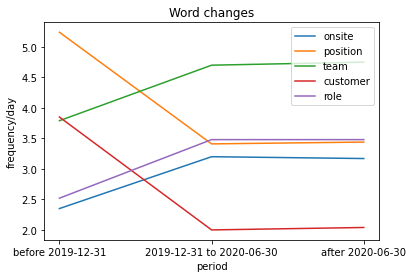

In [81]:
PIT = plot(preplot(relatedword,change1,change2,type1p1),period)